In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_log_error, make_scorer
import warnings
warnings.filterwarnings("ignore")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/Users/j/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
train_df=pd.read_csv("./playground-series-s5e5/train.csv")
test_df=pd.read_csv("./playground-series-s5e5/test.csv")

In [4]:
print("Train df shape:", train_df.shape)
print("Test df shape:", test_df.shape)

Train df shape: (750000, 9)
Test df shape: (250000, 8)


In [5]:
train_df.head()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0


In [7]:
test_df.head()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
0,750000,male,45,177.0,81.0,7.0,87.0,39.8
1,750001,male,26,200.0,97.0,20.0,101.0,40.5
2,750002,female,29,188.0,85.0,16.0,102.0,40.4
3,750003,female,39,172.0,73.0,20.0,107.0,40.6
4,750004,female,30,173.0,67.0,16.0,94.0,40.5


### Checking missing values in the training data

In [9]:
train_df.isna().mean()*100

id            0.0
Sex           0.0
Age           0.0
Height        0.0
Weight        0.0
Duration      0.0
Heart_Rate    0.0
Body_Temp     0.0
Calories      0.0
dtype: float64

### Checking missing values in the testing data

In [11]:
test_df.isna().mean()*100

id            0.0
Sex           0.0
Age           0.0
Height        0.0
Weight        0.0
Duration      0.0
Heart_Rate    0.0
Body_Temp     0.0
dtype: float64

### Converting male to 1 and female to 0 to train model in future

In [13]:
train_df['Sex']=train_df['Sex'].apply(lambda x: 1 if x=="male" else 0)
test_df['Sex']=test_df['Sex'].apply(lambda x: 1 if x=="male" else 0)

In [14]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          750000 non-null  int64  
 1   Sex         750000 non-null  int64  
 2   Age         750000 non-null  int64  
 3   Height      750000 non-null  float64
 4   Weight      750000 non-null  float64
 5   Duration    750000 non-null  float64
 6   Heart_Rate  750000 non-null  float64
 7   Body_Temp   750000 non-null  float64
 8   Calories    750000 non-null  float64
dtypes: float64(6), int64(3)
memory usage: 51.5 MB


In [15]:
test_ids=test_df['id']

In [16]:
train_df.drop(columns=['id'], inplace=True)
test_df.drop(columns=['id'], inplace=True)

### Let's see the distribution of data

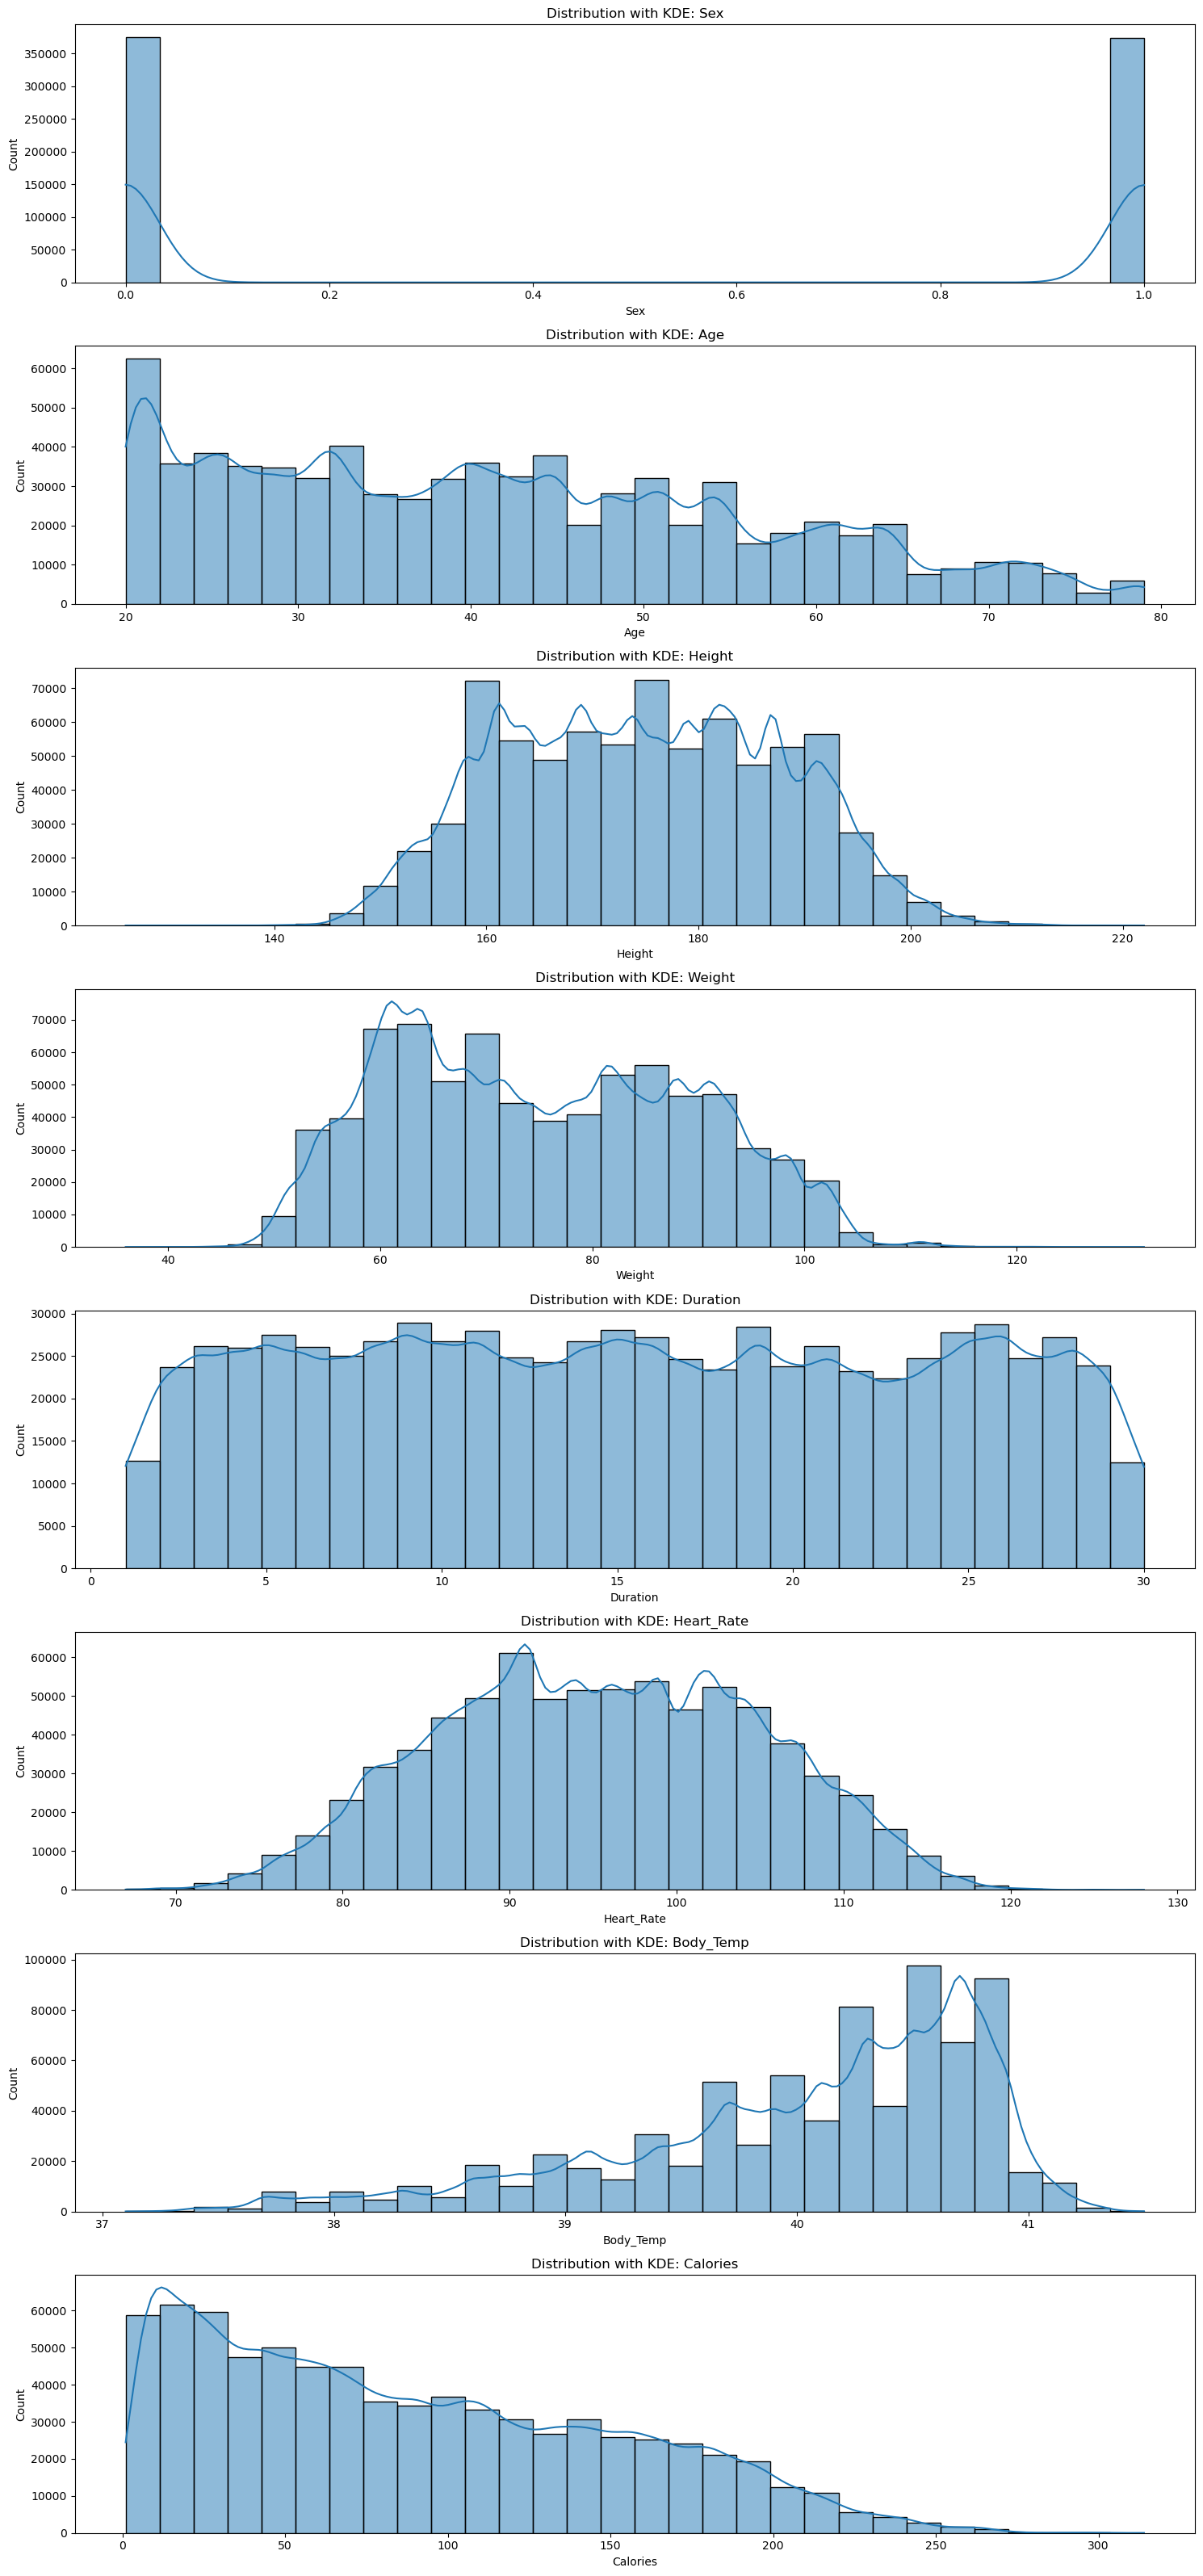

In [18]:
numerical_cols = train_df.select_dtypes(include=['number']).columns

plt.figure(figsize=(15, len(numerical_cols) * 4))

for i, col in enumerate(numerical_cols, 1):
    plt.subplot(len(numerical_cols), 1, i)
    sns.histplot(train_df[col], kde=True, bins=30)
    plt.title(f"Distribution with KDE: {col}")
    plt.xlabel(col)

plt.tight_layout()
plt.show()

In [30]:
def detecting_outliers(val):
    sns.boxplot(x=f'{val}', data=train_df)
    plt.title("Box plot")
    plt.show()

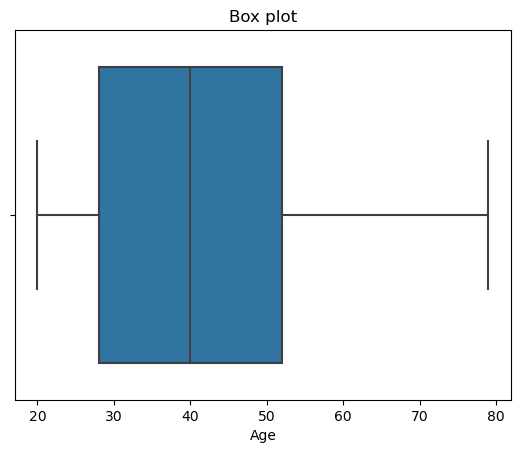

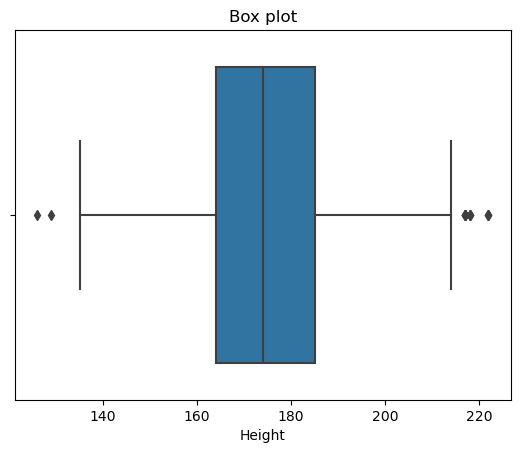

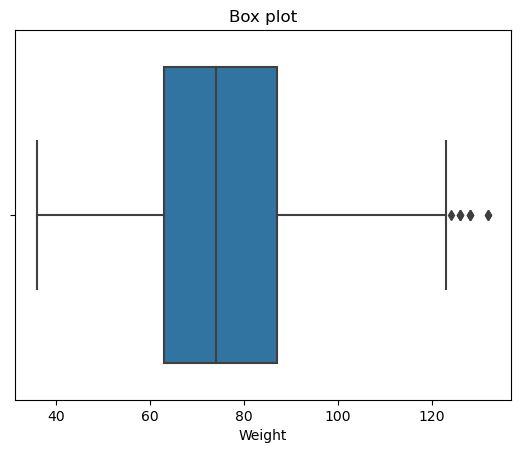

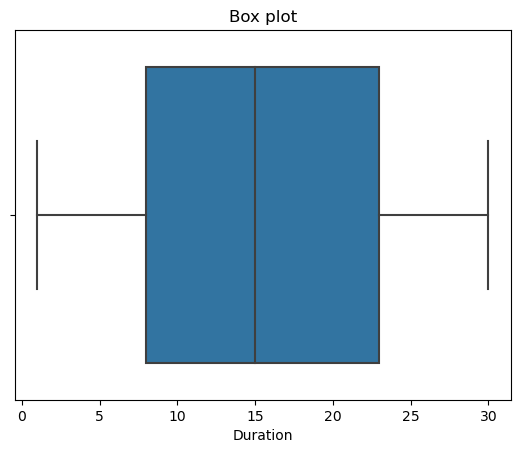

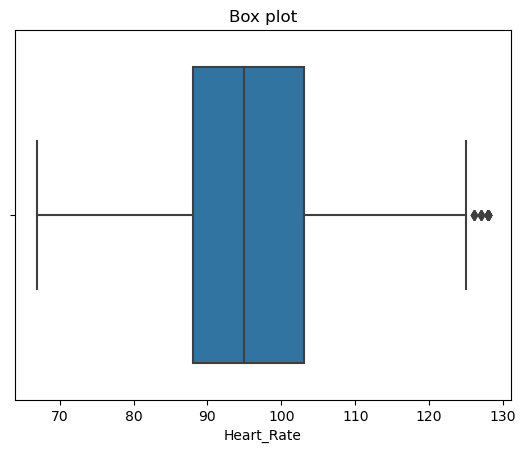

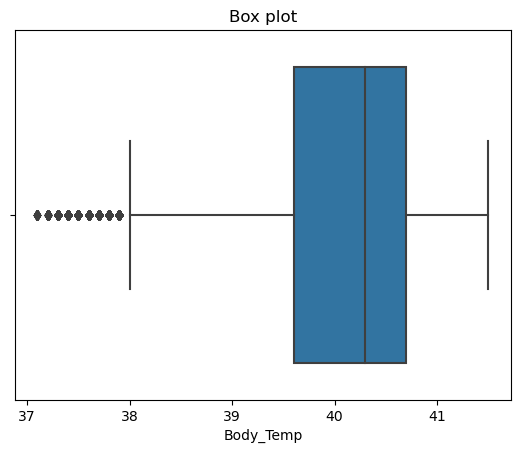

In [31]:
detecting_outliers('Age')
detecting_outliers('Height')
detecting_outliers('Weight')
detecting_outliers('Duration')
detecting_outliers('Heart_Rate')
detecting_outliers('Body_Temp')

### Dealing with the outliers in the training and testing data
1. I am calculating the lower and upper bounds from training data and applying the same to the test data because in real-world situations we do not know what the test data would look like

In [33]:
def get_iqr_bounds(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

def cap_outliers_with_bounds(df, column, lower_bound, upper_bound):
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    return df

numerical_cols = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']
for col in numerical_cols:
    lower, upper = get_iqr_bounds(train_df, col)
    train_df = cap_outliers_with_bounds(train_df, col, lower, upper)
    test_df = cap_outliers_with_bounds(test_df, col, lower, upper)

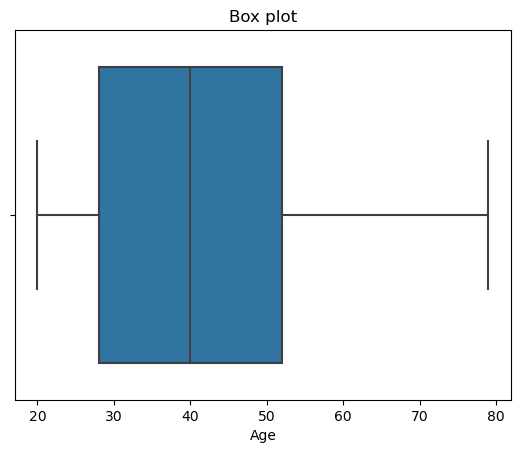

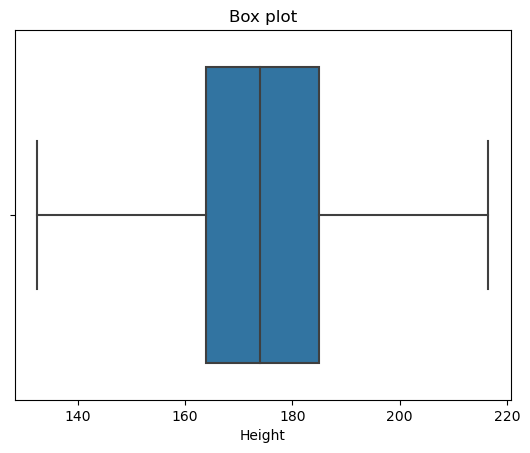

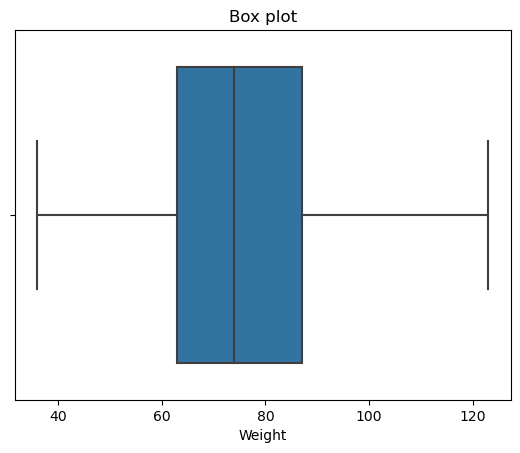

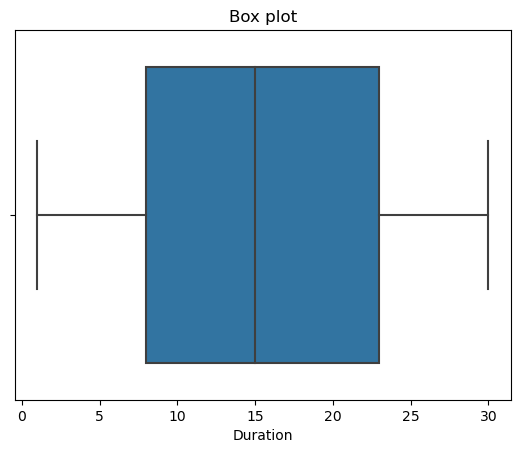

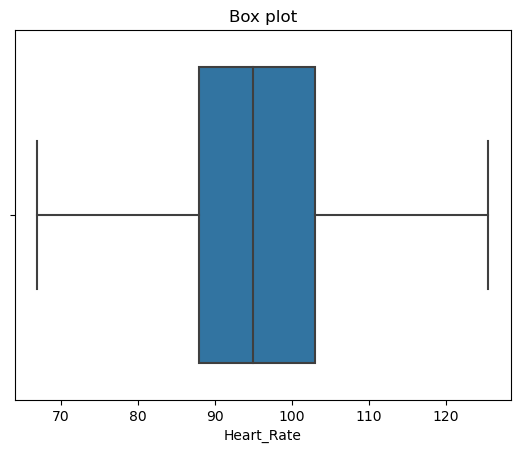

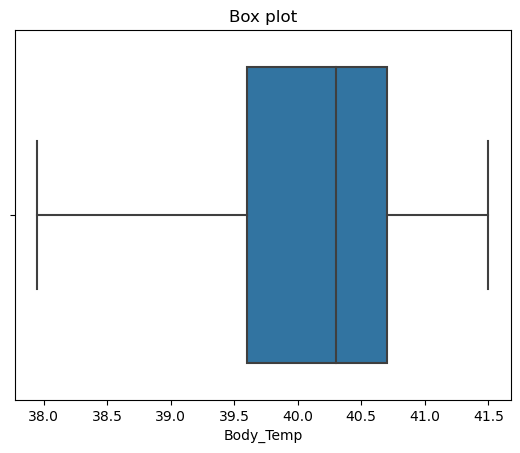

In [34]:
detecting_outliers('Age')
detecting_outliers('Height')
detecting_outliers('Weight')
detecting_outliers('Duration')
detecting_outliers('Heart_Rate')
detecting_outliers('Body_Temp')

### Alright! I have dealt with the outliers now. Let's use StandardScaler

In [41]:
X=train_df.drop(columns=['Calories'])
y=train_df['Calories']

In [43]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2)

In [45]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (600000, 7)
X_test shape: (150000, 7)
y_train shape: (600000,)
y_test shape: (150000,)


In [47]:
scaler=StandardScaler()

X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [49]:
X_train_scaled=pd.DataFrame(X_train_scaled)
X_test_scaled=pd.DataFrame(X_test_scaled)

In [51]:
test_df_scaled=scaler.transform(test_df)
test_df_scaled=pd.DataFrame(test_df_scaled)

In [53]:
linear_model=LinearRegression()
linear_model.fit(X_train_scaled, y_train)

LinearRegression()

In [55]:
linear_pred=linear_model.predict(X_test_scaled)

In [31]:
linear_pred_clipped=np.maximum(0, linear_pred)

In [32]:
(linear_pred_clipped<0).sum()

0

In [33]:
print("Mean Squared Log Error:", mean_squared_log_error(y_test, linear_pred_clipped))
print("Root Mean Squared Log Error:", np.sqrt(mean_squared_log_error(y_test, linear_pred_clipped)))

Mean Squared Log Error: 0.306954966025044
Root Mean Squared Log Error: 0.5540351667764818


In [34]:
predictions1=linear_model.predict(test_df)

In [35]:
predictions1=np.maximum(0, predictions1)

In [36]:
submission1 = pd.DataFrame({'id': test_ids, 'Calories': predictions1})
submission1.to_csv('submission1.csv', index=False)
print("Submission1 file created")

Submission1 file created


In [37]:
dt_model=DecisionTreeRegressor()

dt_model.fit(X_train_scaled, y_train)

DecisionTreeRegressor()

In [38]:
dt_pred=dt_model.predict(X_test_scaled)

In [39]:
dt_pred_clipped=np.maximum(0, dt_pred)

In [40]:
print("Mean Squared Log Error:", mean_squared_log_error(y_test, dt_pred_clipped))
print("Root Mean Squared Log Error:", np.sqrt(mean_squared_log_error(y_test, dt_pred_clipped)))

Mean Squared Log Error: 0.007473592275249796
Root Mean Squared Log Error: 0.08644994086319432


In [41]:
predictions2=dt_model.predict(test_df_scaled)

In [42]:
predictions2=np.maximum(0, predictions2)

In [43]:
submission2=pd.DataFrame({'id': test_ids, 'Calories': predictions2})
submission2.to_csv('submission2.csv', index=False)
print("Submission2 file created")

Submission2 file created


In [57]:
random_model=RandomForestRegressor()

random_model.fit(X_train_scaled, y_train)

RandomForestRegressor()

In [58]:
random_pred=random_model.predict(X_test_scaled)

In [229]:
random_pred_clipped=np.maximum(0, random_pred)

In [230]:
print("Mean Squared Log Error:", mean_squared_log_error(y_test, random_pred_clipped))
print("Root Mean Squared Log Error:", np.sqrt(mean_squared_log_error(y_test, random_pred_clipped)))

Mean Squared Log Error: 0.004216852194640551
Root Mean Squared Log Error: 0.06493729432799422


In [48]:
predictions3=random_model.predict(test_df_scaled)

In [49]:
predictions3=np.maximum(0, predictions3)

In [50]:
submission3=pd.DataFrame({'id': test_ids, 'Calories': predictions3})
submission3.to_csv('submission3.csv', index=False)
print("Submission3 file created")

Submission3 file created


In [98]:
xgb_model=XGBRegressor()

xgb_model.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [102]:
xgb_pred=xgb_model.predict(X_test_scaled)
xgb_pred_clipped=np.maximum(0, xgb_pred)

In [106]:
print("Mean Squared Log Error:", mean_squared_log_error(y_test, xgb_pred_clipped))
print("Root Mean Squared Log Error:", np.sqrt(mean_squared_log_error(y_test, xgb_pred_clipped)))

Mean Squared Log Error: 0.004377543373719538
Root Mean Squared Log Error: 0.06616300608134079


In [110]:
rf=RandomForestRegressor(n_estimators=200, max_features='sqrt', random_state=42)
scores=cross_val_score(rf, X_train_scaled, y_train, scoring='neg_mean_squared_error', cv=5)
print("CV RMSLE (approx):", np.sqrt(-scores.mean()))

CV RMSLE (approx): 3.7930848615088744


In [116]:
rmsle_scorer = make_scorer(mean_squared_log_error, greater_is_better=False)

scores=cross_val_score(rf, X_train_scaled, y_train, scoring=rmsle_scorer, cv=5)
cv_rmsle = np.sqrt(-scores.mean())
print("CV RMSLE:", cv_rmsle)

CV RMSLE: 0.06363460593974422


In [118]:
rf.fit(X_train_scaled, y_train)

RandomForestRegressor(max_features='sqrt', n_estimators=200, random_state=42)

In [120]:
rf_pred=rf.predict(X_test_scaled)
rf_pred_clipped=np.maximum(0, rf_pred)

In [122]:
print("Mean Squared Log Error:", mean_squared_log_error(y_test, rf_pred_clipped))
print("Root Mean Squared Log Error:", np.sqrt(mean_squared_log_error(y_test, rf_pred_clipped)))

Mean Squared Log Error: 0.004047397669540471
Root Mean Squared Log Error: 0.06361916118230788


In [124]:
predictions4=rf.predict(test_df_scaled)
predictions4=np.maximum(0, predictions4)

In [126]:
submission4=pd.DataFrame({'id': test_ids, 'Calories': predictions4})
submission4.to_csv('submission4.csv', index=False)
print("Submission4 file created")

Submission4 file created


### The score decreased on Kaggle and it's not good. Let's get our hands dirty with Feature Engineering and try to increase our rank

In [129]:
train_df.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,1,36,189.0,82.0,26.0,101.0,41.0,150.0
1,0,64,163.0,60.0,8.0,85.0,39.7,34.0
2,0,51,161.0,64.0,7.0,84.0,39.8,29.0
3,1,20,192.0,90.0,25.0,105.0,40.7,140.0
4,0,38,166.0,61.0,25.0,102.0,40.6,146.0


In [39]:
train_df1=train_df.copy()
test_df1=test_df.copy()

### Feature Engineering

In [187]:
train_df1['BMI']=train_df1['Weight']/(train_df1['Height']/100)**2
test_df1['BMI']=test_df1['Weight']/(test_df1['Height']/100)**2

In [189]:
train_df1['Duration_Heart']=train_df1['Duration']*train_df1['Heart_Rate']
test_df1['Duration_Heart']=test_df1['Duration']*test_df1['Heart_Rate']

In [191]:
train_df1['Temp_Effect']=train_df1['Body_Temp']*train_df1['Duration']
test_df1['Temp_Effect']=test_df1['Body_Temp']*test_df1['Duration']

In [199]:
train_df1.drop(columns=['Weight', 'Height'], axis=1, inplace=True)
test_df1.drop(columns=['Weight', 'Height'], axis=1, inplace=True)

In [201]:
X1=train_df1.drop(columns=['Calories'])
y1=train_df1['Calories']

In [203]:
X1_train, X1_test, y1_train, y1_test=train_test_split(X1, y1, test_size=0.2)

In [205]:
X1_train_scaled=scaler.fit_transform(X1_train)
X1_test_scaled=scaler.transform(X1_test)

In [207]:
X1_train_scaled=pd.DataFrame(X1_train_scaled)
X1_test_scaled=pd.DataFrame(X1_test_scaled)

In [209]:
random_model.fit(X1_train_scaled, y1_train)

RandomForestRegressor()

In [210]:
random_pred1=random_model.predict(X1_test_scaled)
random_pred1_clipped=np.maximum(0, random_pred1)

In [215]:
print("Mean Squared Log Error:", mean_squared_log_error(y1_test, random_pred_clipped))
print("Root Mean Squared Log Error:", np.sqrt(mean_squared_log_error(y1_test, random_pred_clipped)))

Mean Squared Log Error: 1.8549341118661529
Root Mean Squared Log Error: 1.361959658677948


### The model's performance decreased after feature engineering so let's add new features smartly to increase the models' performance

<Axes: title={'center': 'Feature Importance'}>

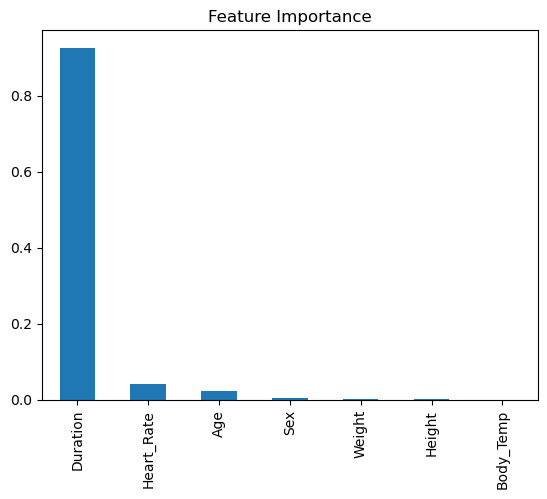

In [59]:
feature_imp=pd.Series(random_model.feature_importances_, index=X_train.columns)
feature_imp.sort_values(ascending=False).plot(kind='bar', title='Feature Importance')

In [77]:
train_df1['Duration_X_HeartRate']=train_df1['Duration']*train_df1['Heart_Rate']
train_df1['Duration_Squared']=train_df1['Duration']**2

test_df1['Duration_X_HeartRate']=test_df1['Duration']*test_df1['Heart_Rate']
test_df1['Duration_Squared']=test_df1['Duration']**2

In [85]:
train_df1.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,Duration_X_HeartRate,Duration_Squared
0,1,36,189.0,82.0,26.0,101.0,41.0,150.0,2626.0,676.0
1,0,64,163.0,60.0,8.0,85.0,39.7,34.0,680.0,64.0
2,0,51,161.0,64.0,7.0,84.0,39.8,29.0,588.0,49.0
3,1,20,192.0,90.0,25.0,105.0,40.7,140.0,2625.0,625.0
4,0,38,166.0,61.0,25.0,102.0,40.6,146.0,2550.0,625.0


In [87]:
test_df1.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Duration_X_HeartRate,Duration_Squared
0,1,45,177.0,81.0,7.0,87.0,39.8,609.0,49.0
1,1,26,200.0,97.0,20.0,101.0,40.5,2020.0,400.0
2,0,29,188.0,85.0,16.0,102.0,40.4,1632.0,256.0
3,0,39,172.0,73.0,20.0,107.0,40.6,2140.0,400.0
4,0,30,173.0,67.0,16.0,94.0,40.5,1504.0,256.0


In [89]:
X2=train_df1.drop(columns=['Calories'])
y2=train_df1['Calories']

In [93]:
X2_train, X2_test, y2_train, y2_test=train_test_split(X2, y2, test_size=0.2, random_state=42)

In [107]:
X2_train_scaled=scaler.fit_transform(X2_train)
X2_test_scaled=scaler.transform(X2_test)

array([[ 1.00167807,  0.10394721,  1.19292835, ..., -1.22647701,
        -1.09318905, -1.01728701],
       [-0.99832474,  0.43339591, -1.53650191, ...,  0.20797248,
        -0.40494463, -0.61287744],
       [ 1.00167807,  0.63106513,  0.95897719, ...,  0.59918597,
        -0.10906385, -0.30957027],
       ...,
       [ 1.00167807, -0.29139122,  1.27091207, ...,  0.85999497,
         1.58903453,  1.78362369],
       [ 1.00167807,  0.03805747,  1.42687952, ..., -0.05283652,
         0.04209264, -0.06992015],
       [ 1.00167807, -0.4231707 ,  0.72502602, ..., -0.70485902,
        -0.62685521, -0.6990017 ]])

In [111]:
test_df1_scaled=scaler.transform(test_df1)

array([[ 1.00167807,  0.23572669,  0.17913997, ..., -0.31364552,
        -0.99992228, -0.96860808],
       [ 1.00167807, -1.01617836,  1.97276557, ...,  0.59918597,
         0.5127146 ,  0.34572301],
       [-0.99832474, -0.81850914,  1.03696091, ...,  0.46878148,
         0.09676626, -0.19348974],
       ...,
       [-0.99832474, -0.68672966, -0.83464841, ...,  0.07756798,
        -0.18196201, -0.41816173],
       [-0.99832474,  1.35585226, -1.30255074, ...,  0.85999497,
         1.18809464,  1.18824294],
       [ 1.00167807, -0.68672966,  1.89478185, ..., -0.18324102,
        -0.07690289, -0.30957027]])

In [113]:
random_model.fit(X2_train_scaled, y2_train)

RandomForestRegressor()

In [117]:
random_pred=random_model.predict(X2_test_scaled)
random_pred_clipped=np.maximum(0, random_pred)

In [119]:
print("Mean Squared Log Error:", mean_squared_log_error(y2_test, random_pred_clipped))
print("Root Mean Squared Log Error:", np.sqrt(mean_squared_log_error(y2_test, random_pred_clipped)))

Mean Squared Log Error: 0.004018685884770931
Root Mean Squared Log Error: 0.06339310597195039


In [127]:
predictions5=random_model.predict(test_df1_scaled)
predictions5=np.maximum(0, predictions5)

In [129]:
submission5=pd.DataFrame({'id': test_ids, 'Calories': predictions5})
submission5.to_csv('submission5.csv', index=False)
print("Submission5 file created")

Submission5 file created


### Dropping low impactful feature

In [133]:
train_df1.drop(columns=['Body_Temp'], inplace=True)
test_df1.drop(columns=['Body_Temp'], inplace=True)

In [136]:
X3=train_df1.drop(columns=['Calories'])
y3=train_df1['Calories']

In [140]:
X3_train, X3_test, y3_train, y3_test=train_test_split(X3, y3, test_size=0.2, random_state=42)

In [142]:
X3_train_scaled=scaler.fit_transform(X3_train)
X3_test_scaled=scaler.transform(X3_test)

In [148]:
test_df3_scaled=scaler.transform(test_df1)

In [150]:
random_model.fit(X3_train_scaled, y3_train)

RandomForestRegressor()

In [151]:
random_pred=random_model.predict(X3_test_scaled)
random_pred_clipped=np.maximum(0, random_pred)

In [153]:
print("Mean Squared Log Error:", mean_squared_log_error(y3_test, random_pred_clipped))
print("Root Mean Squared Log Error:", np.sqrt(mean_squared_log_error(y3_test, random_pred_clipped)))

Mean Squared Log Error: 0.004099832053332594
Root Mean Squared Log Error: 0.06402993091775591


### Let's try the log transformation because I have to find out the RMSLE and this will help because:
1. RMSLE penalizes underestimation more gently than RMSE, especially for large values.
2. It evaluates the error in log-space, not the original space.

In [177]:
train_df2=train_df.copy()
test_df2=test_df.copy()

In [181]:
X4=train_df2.drop(columns=['Calories'])
y4=train_df2['Calories']

In [183]:
X4_train, X4_test, y4_train, y4_test=train_test_split(X4, y4, test_size=0.2)

In [185]:
X4_train_scaled=scaler.fit_transform(X4_train)
X4_test_scaled=scaler.transform(X4_test)

test_df_scaled=scaler.transform(test_df2)

In [187]:
y4_train_log = np.log1p(y4_train)

In [189]:
random_model.fit(X4_train_scaled, y4_train_log)

RandomForestRegressor()

In [191]:
random_pred4=random_model.predict(X4_test_scaled)
random_pred4=np.expm1(random_pred4) 
random_pred4_clipped=np.maximum(0, random_pred4)

In [193]:
print("Mean Squared Log Error:", mean_squared_log_error(y4_test, random_pred4_clipped))
print("Root Mean Squared Log Error:", np.sqrt(mean_squared_log_error(y4_test, random_pred4_clipped)))

Mean Squared Log Error: 0.00413069966326125
Root Mean Squared Log Error: 0.06427051939467464


In [199]:
y3_train_log = np.log1p(y3_train)

In [201]:
random_model.fit(X3_train_scaled, y3_train_log)

RandomForestRegressor()

In [203]:
random_pred5=random_model.predict(X3_test_scaled)
random_pred5=np.expm1(random_pred5) 
random_pred5_clipped=np.maximum(0, random_pred5)

In [204]:
print("Mean Squared Log Error:", mean_squared_log_error(y3_test, random_pred5_clipped))
print("Root Mean Squared Log Error:", np.sqrt(mean_squared_log_error(y3_test, random_pred5_clipped)))

Mean Squared Log Error: 0.004097333050041639
Root Mean Squared Log Error: 0.06401041360623784


In [38]:
train_df3=train_df.copy()
test_df3=test_df.copy()

In [40]:
train_df3['HR_per_min'] = train_df3['Heart_Rate'] / train_df3['Duration']
train_df3['Temp_per_min'] = train_df3['Body_Temp'] / train_df3['Duration']
train_df3['HR_BodyTemp_ratio'] = train_df3['Heart_Rate'] / train_df3['Body_Temp']
train_df3['Weight_per_min'] = train_df3['Weight'] / train_df3['Duration']
train_df3['Duration_squared'] = train_df3['Duration'] ** 2

test_df3['HR_per_min'] = test_df3['Heart_Rate'] / test_df3['Duration']
test_df3['Temp_per_min'] = test_df3['Body_Temp'] / test_df3['Duration']
test_df3['HR_BodyTemp_ratio'] = test_df3['Heart_Rate'] / test_df3['Body_Temp']
test_df3['Weight_per_min'] = test_df3['Weight'] / test_df3['Duration']
test_df3['Duration_squared'] = test_df3['Duration'] ** 2

In [42]:
train_df3.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,HR_per_min,Temp_per_min,HR_BodyTemp_ratio,Weight_per_min,Duration_squared
0,1,36,189.0,82.0,26.0,101.0,41.0,150.0,3.884615,1.576923,2.463415,3.153846,676.0
1,0,64,163.0,60.0,8.0,85.0,39.7,34.0,10.625000,4.962500,2.141058,7.500000,64.0
2,0,51,161.0,64.0,7.0,84.0,39.8,29.0,12.000000,5.685714,2.110553,9.142857,49.0
3,1,20,192.0,90.0,25.0,105.0,40.7,140.0,4.200000,1.628000,2.579853,3.600000,625.0
4,0,38,166.0,61.0,25.0,102.0,40.6,146.0,4.080000,1.624000,2.512315,2.440000,625.0


In [44]:
X5=train_df3.drop(columns=['Calories'])
y5=train_df3['Calories']

In [46]:
X5_train, X5_test, y5_train, y5_test=train_test_split(X5, y5, test_size=0.2)

In [48]:
scaler=StandardScaler()

X5_train_scaled=scaler.fit_transform(X5_train)
X5_test_scaled=scaler.transform(X5_test)

test_df3_scaled=scaler.transform(test_df3)

In [58]:
y5_train_log = np.log1p(y5_train)

ridge = Ridge()
ridge.fit(X5_train_scaled, y5_train_log)

y_pred_log = ridge.predict(X5_test_scaled)

y_pred = np.expm1(y_pred_log)
y_pred_clipped=np.maximum(0, y_pred)

rmsle = mean_squared_log_error(y5_test, y_pred_clipped, squared=False)
print("RMSLE:", rmsle)

RMSLE: 0.09895356516231604


In [48]:
train_df6=train_df.copy()
test_df6=test_df.copy()

In [50]:
X6=train_df6.drop(columns=['Calories'])
y6=train_df6['Calories']

In [52]:
X6_train, X6_test, y6_train, y6_test=train_test_split(X6, y6, test_size=0.2)

In [58]:
scaler=StandardScaler()

X6_train_scaled=scaler.fit_transform(X6_train)
X6_test_scaled=scaler.transform(X6_test)

test_df6_scaled=scaler.transform(test_df6)

In [60]:
rf=RandomForestRegressor(n_estimators=500, random_state=42)
gb=GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, random_state=42)

rf.fit(X6_train_scaled, np.log1p(y6_train))
gb.fit(X6_train_scaled, np.log1p(y6_train))

GradientBoostingRegressor(learning_rate=0.05, n_estimators=300, random_state=42)

In [62]:
rf_pred = np.expm1(rf.predict(X6_test_scaled))
gb_pred = np.expm1(gb.predict(X6_test_scaled))

In [64]:
blended_pred = (0.6 * rf_pred) + (0.4 * gb_pred)

In [68]:
rmsle = mean_squared_log_error(y6_test, blended_pred, squared=False)
print("RMSLE of Blended Model:", rmsle)

RMSLE of Blended Model: 0.06107629412610681


In [70]:
blended_pred = 0.5 * rf.predict(test_df6_scaled) + 0.5 * gb.predict(test_df6_scaled)

In [72]:
predictions6=blended_pred

In [76]:
submission6=pd.DataFrame({'id': test_ids, 'Calories': predictions6})
submission6.to_csv('submission6.csv', index=False)
print("Submission6 file created")

Submission6 file created


In [80]:
gb_pred=gb.predict(X6_test_scaled)

In [82]:
print("Root Mean Sqaured Log Error:", np.sqrt(mean_squared_log_error(y6_test, gb_pred)))

Root Mean Sqaured Log Error: 2.633753296641837


In [124]:
y6_train_log = np.log1p(y6_train)

In [126]:
base_model = DecisionTreeRegressor(random_state=42)

bagging_model = BaggingRegressor(
    base_estimator=base_model,
    n_estimators=100,
    max_samples=0.8,
    max_features=1.0,
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

# Fit the model
bagging_model.fit(X6_train_scaled, y6_train_log)

BaggingRegressor(base_estimator=DecisionTreeRegressor(random_state=42),
                 max_samples=0.8, n_estimators=100, n_jobs=-1, random_state=42)

In [128]:
bagging_pred=bagging_model.predict(X6_test_scaled)

In [130]:
bagging_pred=np.expm1(bagging_pred)

In [132]:
print("Root Mean Sqaured Log Error:", np.sqrt(mean_squared_log_error(y6_test, bagging_pred)))

Root Mean Sqaured Log Error: 0.06252966292093705


In [134]:
bagging_preds = bagging_model.predict(X6_test_scaled)
rf_preds = rf.predict(X6_test_scaled)

blended_preds = 0.4 * bagging_preds + 0.6 * rf_preds

In [135]:
print("Root Mean Sqaured Log Error:", np.sqrt(mean_squared_log_error(y6_test, blended_preds)))

Root Mean Sqaured Log Error: 2.6337951165921494


In [102]:
blended_preds = 0.4 * bagging_model.predict(X6_test_scaled) + 0.6 * rf.predict(X6_test_scaled)

In [106]:
prediction7 = 0.5 * bagging_model.predict(test_df6_scaled) + 0.5 * rf.predict(test_df6_scaled)

In [112]:
submission7=pd.DataFrame({'id': test_ids, 'Calories': prediction7})
submission7.to_csv('submission7.csv', index=False)
print("Submission7 file created")

Submission7 file created


In [221]:
train_df7=train_df.copy()
test_df7=test_df.copy()

In [223]:
train_df7['Duration^2']=train_df7['Duration']**2
test_df7['Duration^2']=test_df7['Duration']**2

In [254]:
train_df7.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,Duration^2
0,1,36,189.0,82.0,26.0,101.0,41.0,150.0,676.0
1,0,64,163.0,60.0,8.0,85.0,39.7,34.0,64.0
2,0,51,161.0,64.0,7.0,84.0,39.8,29.0,49.0
3,1,20,192.0,90.0,25.0,105.0,40.7,140.0,625.0
4,0,38,166.0,61.0,25.0,102.0,40.6,146.0,625.0


In [256]:
test_df7.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Duration^2
0,1,45,177.0,81.0,7.0,87.0,39.8,49.0
1,1,26,200.0,97.0,20.0,101.0,40.5,400.0
2,0,29,188.0,85.0,16.0,102.0,40.4,256.0
3,0,39,172.0,73.0,20.0,107.0,40.6,400.0
4,0,30,173.0,67.0,16.0,94.0,40.5,256.0


In [258]:
X7=train_df7.drop(columns=['Calories'])
y7=train_df7['Calories']

In [260]:
X7_train, X7_test, y7_train, y7_test=train_test_split(X7, y7, test_size=0.2)

In [262]:
scaler=StandardScaler()

X7_train_scaled=scaler.fit_transform(X7_train)
X7_test_scaled=scaler.transform(X7_test)

test_df7_scaled=scaler.transform(test_df7)

In [264]:
y7_train_log = np.log1p(y7_train)
y7_test_log = np.log1p(y7_test)

In [239]:
cat_model = CatBoostRegressor(verbose=0, random_state=42)
cat_model.fit(X7_train_scaled, y7_train_log)

In [240]:
y_pred_log = cat_model.predict(X7_test_scaled)
y_pred = np.expm1(y_pred_log)

In [241]:
print("Root Mean Squared Log Error:", np.sqrt(mean_squared_log_error(y7_test, y_pred)))

Root Mean Squared Log Error: 0.0590459625077076


In [88]:
predictions8=cat_model.predict(test_df7_scaled)
predictions8=np.expm1(predictions8)

In [90]:
submission8=pd.DataFrame({'id': test_ids, 'Calories': predictions8})
submission8.to_csv('submission8.csv', index=False)
print("Submission8 file created")

Submission8 file created


### Let's try tuning CatBoostRegressor model

In [252]:
X8_train.head()

,Sex,Age,Weight,Duration,Heart_Rate,Body_Temp,Duration^2,Duration_HeartRate,Age^2
150435,1,42,99.0,16.0,98.0,39.9,256.0,1568.0,1764
735579,1,26,87.0,18.0,102.0,40.2,324.0,1836.0,676
507726,1,57,82.0,5.0,86.0,39.4,25.0,430.0,3249
397733,0,35,52.0,25.0,108.0,41.3,625.0,2700.0,1225
625298,0,29,70.0,14.0,89.0,40.6,196.0,1246.0,841


In [266]:
param_dist = {
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'iterations': [300, 500, 700],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'bagging_temperature': [0, 0.5, 1, 2],
    'random_strength': [0.5, 1, 2],
}

random_search = RandomizedSearchCV(
    cat_model,
    param_distributions=param_dist,
    n_iter=30,
    cv=3,
    scoring='neg_mean_squared_log_error',
    verbose=1,
    n_jobs=-1
)
random_search.fit(X7_train_scaled, y7_train_log)

best_cat = random_search.best_estimator_

Fitting 3 folds for each of 30 candidates, totalling 90 fits


/Users/j/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/j/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/j/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/j/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/j/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or

In [270]:
y_pred_log = best_cat.predict(X7_test_scaled)
y_pred = np.expm1(y_pred_log)

# RMSLE
rmsle = np.sqrt(mean_squared_log_error(y7_test, y_pred))
print("Tuned CatBoost RMSLE:", rmsle)

Tuned CatBoost RMSLE: 0.05992270421169554


### Great! Rank: 564/1673. Big achievement

### Blended model with RandomForestRegressor and CatBoostRegressor

In [114]:
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X7_train_scaled, y7_train_log)

cat_model = CatBoostRegressor(verbose=0, random_state=42)
cat_model.fit(X7_train_scaled, y7_train_log)


rf_pred_log = rf_model.predict(X7_test_scaled)
cat_pred_log = cat_model.predict(X7_test_scaled)

In [118]:
blended_pred_log = 0.1 * rf_pred_log + 0.9 * cat_pred_log
blended_pred = np.expm1(blended_pred_log)

rmsle = np.sqrt(mean_squared_log_error(y7_test, blended_pred))
print("Blended RMSLE:", rmsle)

Blended RMSLE: 0.05905020700467482


In [120]:
rf_test_log = rf_model.predict(test_df7_scaled)
cat_test_log = cat_model.predict(test_df7_scaled)

# Blend and reverse transform
final_pred_log = 0.1 * rf_test_log + 0.9 * cat_test_log

In [122]:
predictions9=np.expm1(final_pred_log)

In [124]:
submission9=pd.DataFrame({'id': test_ids, 'Calories': predictions9})
submission9.to_csv('submission9.csv', index=False)
print("Submission9 file created")

Submission9 file created


### Great!!!!! Rank: 495/1675

In [68]:
cat_model=CatBoostRegressor(verbose=0, random_state=42)
cat_model.fit(X7_train, y7_train)

In [69]:
cat_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,Duration^2,37.735463
1,Duration,25.454283
2,Heart_Rate,20.295126
3,Age,11.540043
4,Sex,2.812843
5,Weight,1.054361
6,Body_Temp,1.023787
7,Height,0.084094


### Let's add some more features from the important ones and then apply CatBoostRegressor and check the performance

In [193]:
train_df8=train_df.copy()
test_df8=test_df.copy()

In [195]:
#For training data
train_df8['Duration^2']=train_df8['Duration']**2
train_df8['Duration_HeartRate']=train_df8['Duration']*train_df8['Heart_Rate']
train_df8['Age^2']=train_df8['Age']**2
train_df8.drop(columns=['Height'], inplace=True)

#For test data
test_df8['Duration^2']=test_df8['Duration']**2
test_df8['Duration_HeartRate']=test_df8['Duration']*train_df8['Heart_Rate']
test_df8['Age^2']=test_df8['Age']**2
test_df8.drop(columns=['Height'], inplace=True)

In [197]:
train_df8.head()

,Sex,Age,Weight,Duration,Heart_Rate,Body_Temp,Calories,Duration^2,Duration_HeartRate,Age^2
0,1,36,82.0,26.0,101.0,41.0,150.0,676.0,2626.0,1296
1,0,64,60.0,8.0,85.0,39.7,34.0,64.0,680.0,4096
2,0,51,64.0,7.0,84.0,39.8,29.0,49.0,588.0,2601
3,1,20,90.0,25.0,105.0,40.7,140.0,625.0,2625.0,400
4,0,38,61.0,25.0,102.0,40.6,146.0,625.0,2550.0,1444


In [199]:
test_df8.head()

,Sex,Age,Weight,Duration,Heart_Rate,Body_Temp,Duration^2,Duration_HeartRate,Age^2
0,1,45,81.0,7.0,87.0,39.8,49.0,707.0,2025
1,1,26,97.0,20.0,101.0,40.5,400.0,1700.0,676
2,0,29,85.0,16.0,102.0,40.4,256.0,1344.0,841
3,0,39,73.0,20.0,107.0,40.6,400.0,2100.0,1521
4,0,30,67.0,16.0,94.0,40.5,256.0,1632.0,900


In [201]:
X8=train_df8.drop(columns=['Calories'])
y8=train_df8['Calories']

In [203]:
X8_train, X8_test, y8_train, y8_test=train_test_split(X8, y8, test_size=0.2)

In [205]:
scaler=StandardScaler()

X8_train_scaled=scaler.fit_transform(X8_train)
X8_test_scaled=scaler.transform(X8_test)

In [207]:
test_df8=test_df8[X8_train.columns]
test_df8_scaled=scaler.transform(test_df8)

In [209]:
y8_train_log=np.log1p(y8_train)
y8_test_log=np.log1p(y8_test)

In [211]:
cat_model=CatBoostRegressor(verbose=0, random_state=42)
cat_model.fit(X8_train_scaled, y8_train_log)

In [212]:
y8_pred_log = cat_model.predict(X8_test_scaled)
y8_pred = np.expm1(y8_pred_log)

In [213]:
print("Root Mean Squared Log Error:", np.sqrt(mean_squared_log_error(y8_test, y8_pred)))

Root Mean Squared Log Error: 0.0591647372957825


In [217]:
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X8_train_scaled, y8_train_log)

cat_model = CatBoostRegressor(verbose=0, random_state=42)
cat_model.fit(X8_train_scaled, y8_train_log)


rf_pred_log = rf_model.predict(X8_test_scaled)
cat_pred_log = cat_model.predict(X8_test_scaled)

In [218]:
blended_pred_log = 0.1 * rf_pred_log + 0.9 * cat_pred_log
blended_pred = np.expm1(blended_pred_log)

rmsle = np.sqrt(mean_squared_log_error(y8_test, blended_pred))
print("Blended RMSLE:", rmsle)

Blended RMSLE: 0.05909893871178786
